In [1]:
import os
import sys
import re
import pandas as pd
from Bio import SeqIO

print(sys.version)

3.11.3 (main, May 15 2023, 10:43:03) [Clang 14.0.6 ]


# Preprocessing of raw reads

### Preprocessing steps were completed on HPC using batch scripts.
### FASTQ reads are trimmed then mapped to reference genomes.
### Mapped BAM files are used for peak calling using MACS2. 
### The output NarrowPeak fiels are used for downstream analyses.
### https://github.com/yunfei-dai/geisingerlab-chipseq-almc-jb/tree/master/sbatch_scripts

### Find intersected peaks among replicates

In [23]:
def get_replicates(INPUT_DIR, OUTPUT_DIR, samples):
    # recognize replicates from .narrowPeak files
    for sample in samples:
        replicates = []
        for file in os.listdir(INPUT_DIR):
            if re.match("^" + str(sample) + ".+.narrowPeak$", file):
                replicates.append(os.path.join(INPUT_DIR, file))
        outfile =os.path.join(OUTPUT_DIR, (str(sample) + ".intersect.bed"))
        cmd = ' '.join(["bedtools multiinter -cluster -header -i ", " ".join(replicates), " > ", outfile]) 
        os.system(cmd)


In [24]:
narrowPeak = "/Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/MACS2_output/narrowPeak"
bed_multiinter = "/Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/bed_multiinter"
!mkdir -p $bed_multiinter
get_replicates(narrowPeak, bed_multiinter, ['WTcntrl_BEADS', 'JBA71FLAG_BEADS'])

sh: line 1: 92960 Segmentation fault: 11  bedtools multiinter -cluster -header -i /Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/MACS2_output/narrowPeak/WTcntrl_BEADS_1.ext_size200_peaks.narrowPeak /Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/MACS2_output/narrowPeak/WTcntrl_BEADS_2.ext_size200_peaks.narrowPeak /Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/MACS2_output/narrowPeak/WTcntrl_BEADS_3.ext_size200_peaks.narrowPeak > /Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/bed_multiinter/WTcntrl_BEADS.intersect.bed


An intersected bed file is generated for WT and JBA71FLAG

In [26]:
!ls $bed_multiinter | cat

JBA71FLAG_BEADS.intersect.bed
WTcntrl_BEADS.intersect.bed


### Calculate average peak position for intersected peaks

In [27]:
INDIR = "/Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/bed_multiinter"
OUTDIR = "/Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/average_peak_summit"
SCRIPT = "/Users/yunfei/GitProjects/geisingerlab/geisingerlab-chipseq-bfmrs/src/find_peak_summit.py"
!mkdir -p $OUTDIR

for file in os.listdir(INDIR):
    if re.match("^.+" + "intersect.bed$", file):
        infile = os.path.join(INDIR, file)
        outfile = os.path.join(OUTDIR, (file.split('.')[0] + '.average_summit.bed'))
        cmd = "python " + SCRIPT + " " + infile + " " + outfile
        print("new output: " + outfile)
        os.system(cmd)

new output: /Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/average_peak_summit/WTcntrl_BEADS.average_summit.bed
new output: /Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/average_peak_summit/JBA71FLAG_BEADS.average_summit.bed


In [28]:
!head /Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/average_peak_summit/JBA71FLAG_BEADS.average_summit.bed

	chrom	start	end	original_peak_offset	average_summit	original_enrichment	average_enrichment
0	NZ_CP012004.1	235728	235928	127;100	235841	1.98;2.30	2.14
1	NZ_CP012004.1	373874	374132	146;138	374016	1.54;2.40	1.97
2	NZ_CP012004.1	376473	376887	119;108	376586	2.30;2.41	2.35
3	NZ_CP012004.1	668966	669175	162;92	669093	2.60;2.20	2.40
4	NZ_CP012004.1	670100	670372	331;213;171	670338	2.27;2.77;1.61	2.22
5	NZ_CP012004.1	726295	726511	184;176;103	726449	2.56;3.00;1.90	2.49
6	NZ_CP012004.1	772526	772737	115;135	772651	1.97;2.59	2.28
7	NZ_CP012004.1	825473	825934	332;322	825800	1.67;1.81	1.74
8	NZ_CP012004.1	860833	861149	175;175	861008	2.26;3.44	2.85


### Nearest ORF identification of JBA71FLAG peaks

In [29]:
from matplotlib import pyplot as plt
from Bio import SeqIO
from scipy.stats import norm
from bisect import bisect_left

In [38]:
def nearest_ORF(INDIR, OUTDIR, annotation, script):
    for file in os.listdir(INDIR):
        if re.match("^.+" + "average_summit.bed$", file):
            infile = os.path.join(INDIR, file)
            outfile = os.path.join(OUTDIR, (file.split('.')[0] + '.nearest_orf.tsv'))
            plot = os.path.join(OUTDIR, (file.split('.')[0] + '.nearest_orf.tiff'))
            cmd = " ".join(["python ", script, " ", infile, " ", annotation, " ", outfile, " ", plot])
            print("new output: " + outfile)
            os.system(cmd)

In [39]:
average_peak = "/Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/average_peak_summit"
annotation = "/Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/annotations"
peak_stat = "/Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/peak_stat"
script = "/Users/yunfei/GitProjects/geisingerlab/geisingerlab-chipseq-bfmrs/src/distance_to_orf.py"

!mkdir -p $peak_stat
nearest_ORF(average_peak, peak_stat, annotation, script)

new output: /Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/peak_stat/WTcntrl_BEADS.nearest_orf.tsv


Traceback (most recent call last):
  File "/Users/yunfei/GitProjects/geisingerlab/geisingerlab-chipseq-bfmrs/src/distance_to_orf.py", line 156, in <module>
    main()
  File "/Users/yunfei/GitProjects/geisingerlab/geisingerlab-chipseq-bfmrs/src/distance_to_orf.py", line 153, in main
    make_histogram(infile, outfile, distance_plot, gene_dict, start_codon_dict)
  File "/Users/yunfei/GitProjects/geisingerlab/geisingerlab-chipseq-bfmrs/src/distance_to_orf.py", line 116, in make_histogram
    bins = np.arange(np.min(distance_list_coding), np.max(distance_list_coding), 20)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yunfei/opt/anaconda3/envs/ChipSeq/lib/python3.11/site-packages/numpy/core/fromnumeric.py", line 2953, in min
    return _wrapreduction(a, np.minimum, 'min', axis, None, out,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yunfei/opt/anaconda3/envs/ChipSeq/lib/python3.11/site-packages/numpy/core/fromnumeric.py", line 88, in _w

new output: /Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/peak_stat/JBA71FLAG_BEADS.nearest_orf.tsv


Note: empty values in WT caused errors in generating histogram

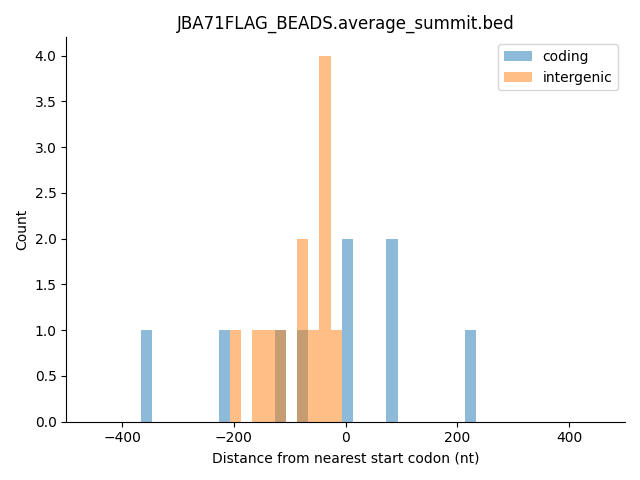

In [40]:
from PIL import Image
Image.open("/Users/yunfei/EG_lab_bioinfo_projects/2023_Sep_ALMC_Jinna_ChIPSeq_analysis_YD/peak_stat/JBA71FLAG_BEADS.nearest_orf.tiff")

### Link peak stat with RNASeq tables

In [ ]:
def read_rnaseq_table(file):
    df = pd.read_excel(file, engine='openpyxl')
    df = df.set_index("gene_id")
    return df

rnaseq_table = {}
rnaseq_table.update({"BfmRS_WT" : read_rnaseq_table(rnaseq_bfmRS)})
rnaseq_table.update({"BfmR_WT" : read_rnaseq_table(rnaseq_bfmR)})
rnaseq_table.update({"BfmS_WT" : read_rnaseq_table(rnaseq_bfmS)})

test_table = read_rnaseq_table(rnaseq_bfmRS)

df_chipseq = pd.read_csv(infile, sep='\t', index_col=0)
df_chipseq = df_chipseq.set_index("locus_tag")

col_names = ["log2(fold_change)", "significant", "protein_id", "product"]

for i,j in rnaseq_table.items():
    df_rnaseq = j
    for row, column in df_chipseq.iterrows():
        for k in col_names:
            new_column_name = i + "_" + k
            try:
                df_chipseq.loc[row, new_column_name] = df_rnaseq.loc[row,k]
            except:
                pass
df_chipseq.to_csv(outfile, sep='\t')